# "Molecular subtyping of hypertensive disorders of pregnancy"

This notebook contains the code to generate the following figures and analyses:
* Figures 2d, 2e
* Figure 3
* Figure 4a, 4b, and 4d
* Extended Data Fig. 1
* Extended Data Fig. 3
* Supplementary Table 1
* Analysis for days spent in the NICU (main text & supplementary information)

To run this notebook, edit the `input_path` variable in the following cell to point to the location containing these files:
* gene_space.json
* sample_data_scaled.feather
* fig3_de_data.feather
* fig4ab_de_data.feather
* suppl_tbl1_data.feather

In [1]:
# Edit this path to location of folder of input files
input_path = "."

Run the following cells to generate the figures.

# Load Inputs

In [2]:
# Load Libraries
import json
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib_venn import venn2
from scipy.stats import ks_2samp

In [3]:
# Load helper functions  
%run ./Figures_2d_2e_3_4a_4b_4d_Extended_Data_1_3_Suppl_Tbl_1_NICU_helper.py

In [4]:
# Set paths to input files
parent_path = Path(input_path)

# Path to genes analyzed
input_gene_json_file_path = parent_path / "genes_space.json"

# Path to rescaled sample dataframe
input_sample_data_scaled_file_path = parent_path / "sample_data_scaled.feather"

# Path to DE results for Figure 3
input_fig3_de_data_file_path = parent_path / "fig3_de_data.feather"

# Path to DE results for Figures 4a and 4b
input_fig4ab_de_data_file_path = parent_path / "fig4ab_de_data.feather"

# Path to DE results for Supplemental Table 1
input_suppl_tbl1_data_file_path = parent_path / "suppl_tbl1_data.feather"

In [5]:
# Load genes analyzed
with open(input_gene_json_file_path) as f:
    gene_space = json.load(f)
print(f"Number of genes from training: {len(gene_space["all_genes"])}")

Number of genes from training: 2036


In [6]:
# Load dataframes
sample_data_scaled = pd.read_feather(input_sample_data_scaled_file_path)
assert len(sample_data_scaled) == 5399

fig3_de_data = pd.read_feather(input_fig3_de_data_file_path)
assert len(fig3_de_data) == 2*len(gene_space["all_genes"]), "Mismatch between input genes and Figure 3 DE data"

fig4ab_de_data = pd.read_feather(input_fig4ab_de_data_file_path)
assert len(fig4ab_de_data) == 2*len(gene_space["all_genes"]), "Mismatch between input genes and Figure 4 DE data"

suppl_tbl1_data = pd.read_feather(input_suppl_tbl1_data_file_path)
assert len(suppl_tbl1_data) == len(gene_space["all_genes"]), "Mismatch between input genes and Supplemental Table 1 DE data"

# Figure 2d

PAPPA2 expression in early-onset PE split into placental-driven and immune-driven HDP among individuals without high risk factors.

In [7]:
sample_data_scaled.groupby(["early_onset", "hdp_vanity_group"])["is_nmrf"].value_counts()

early_onset  hdp_vanity_group                        is_nmrf
False        Control                                 True       3472
                                                     False       661
             GHTN                                    True        512
                                                     False       103
             PE, Ambiguous                           True         11
                                                     False         2
             Postpartum PE                           True         87
                                                     False        26
             Preterm PE, Not Severe                  True          7
                                                     False         4
             Preterm PE, Severe                      False        59
                                                     True         42
             Term PE,  Not Severe, Term Diagnosis    True        114
                                          

hdp_severity_vanity
Placental-driven    29
Immune-driven        6
Name: count, dtype: int64


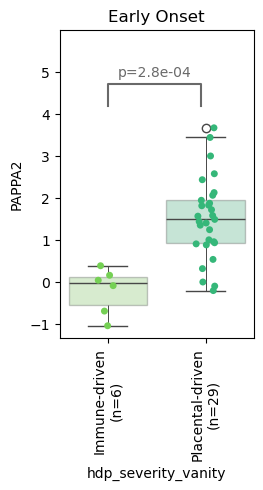

In [8]:
# Select early onset PE w/o high risk factors 
df = sample_data_scaled.dropna(subset=["early_onset"]).reset_index(drop=True)
df = df[
    (df["hdp_vanity_group"] != "PE, Ambiguous")
     & (df["early_onset"] == True)
    & (df["is_nmrf"] == True)
].reset_index(drop=True)
assert len(df) == 1+3+26+5, f"Expect 35 samples, got {len(df)}"
print(df["hdp_severity_vanity"].value_counts(sort=False))

# Define boxplot colors
green_colors = [     
        [(0.709898+9*0.430983)/10, (0.868751+9*0.808473)/10, (0.169257+9*0.346476)/10, 1.      ], #yellow
        [0.20803,  0.718701, 0.472873, 1.      ] # green
    ]

# Generate boxplot
fig = plot_boxplots_with_pvals(
    plot_df=df,
    x="hdp_severity_vanity",
    y="PAPPA2",
    order=[ "Immune-driven", "Placental-driven"],
    contrasts= [("Immune-driven", "Placental-driven")],
    fig_size= (2.5, 4),
    title="Early Onset",
    p_sig_thresh = 0.05,
    mw_alt = "two-sided",
    multiple_test_corr_method= "bonferroni",
    palette = green_colors
)

# Figure 2e

PAPPA2 expression in PE with severe features split into placental-driven and immune-driven HDP among individuals without high risk factors.

In [9]:
sample_data_scaled.groupby("hdp_vanity_group")["is_nmrf"].value_counts()

hdp_vanity_group                        is_nmrf
Control                                 True       3472
                                        False       661
GHTN                                    True        512
                                        False       103
PE, Ambiguous                           True         11
                                        False         2
Postpartum PE                           True         88
                                        False        26
Preterm PE, Not Severe                  True         10
                                        False         8
Preterm PE, Severe                      False        90
                                        True         68
Term PE,  Not Severe, Term Diagnosis    True        114
                                        False        26
Term PE, Not Severe, Preterm Diagnosis  True         32
                                        False        22
Term PE, Severe, Preterm Diagnosis      False        13


hdp_severity_vanity
Placental-driven    77
Immune-driven       86
Name: count, dtype: int64


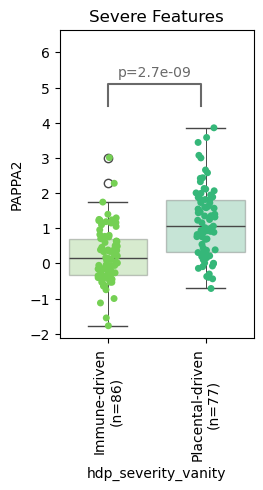

In [10]:
#  Select Severe Features w/o high risk factors
df = sample_data_scaled[
    (sample_data_scaled["hdp_vanity_group"] != "PE, Ambiguous")
    & (sample_data_scaled["hdp_vanity_group"].isin([
        "Preterm PE, Severe", 
        "Term PE, Severe, Preterm Diagnosis", 
        "Term PE, Severe, Term Diagnosis"      
        ])
      )
    & (sample_data_scaled["is_nmrf"] ==True)
].reset_index(drop=True)
assert len(df) == 68+9+86, f"Expect 163 samples, got {len(df)}"
print(df["hdp_severity_vanity"].value_counts(sort=False))

fig = plot_boxplots_with_pvals(
    plot_df=df,
    x= "hdp_severity_vanity",
    y="PAPPA2",
    order=[ "Immune-driven", "Placental-driven"],
    contrasts= [("Immune-driven", "Placental-driven")],
    fig_size= (2.5, 4),
    title="Severe Features",
    p_sig_thresh = 0.05,
    mw_alt = "two-sided",
    multiple_test_corr_method= "bonferroni",
    palette = green_colors
    )

# Figure 3a, 3b

* Figure 3a: Immune-driven PE versus non HDP
* Figure 3b: Immune-driven GHTN versus non HDP 

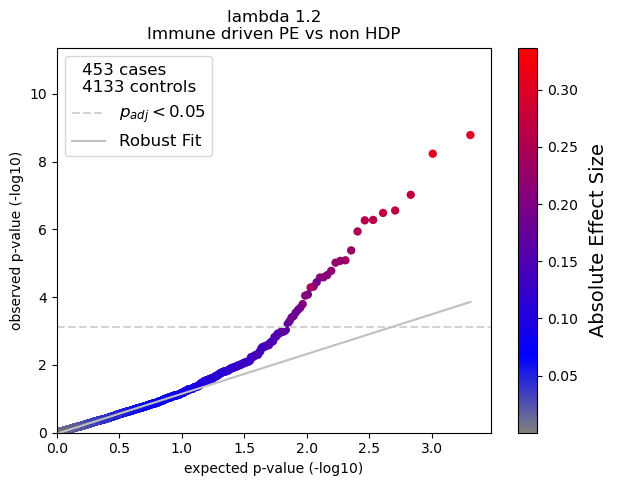

   feature        pvalue  cohens_d
0  SLCO2B1  1.635354e-09  0.299566
1    CD163  5.825681e-09  0.306067
2      AXL  9.495952e-08  0.268741
3    STAB1  2.763036e-07  0.262429
4    FCGBP  3.259406e-07  0.269123
5     MRC1  5.237307e-07  0.258176
6     C1QC  5.389135e-07  0.257887
7   IGSF21  1.148418e-06  0.247653
8    VSIG4  4.156829e-06  0.229946
9   LILRB5  8.136458e-06  0.237833




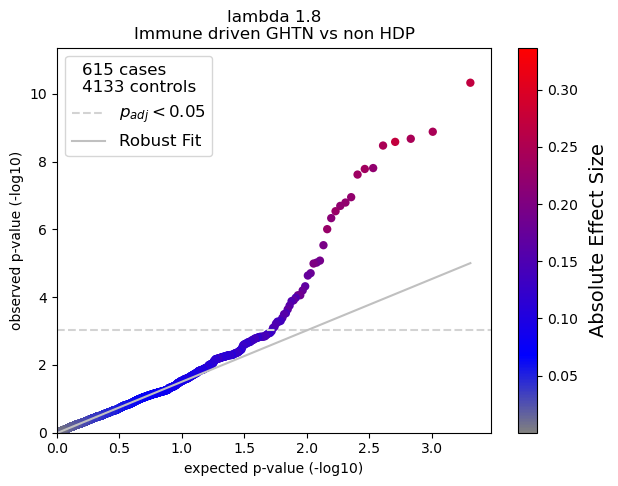

   feature        pvalue  cohens_d
0     C1QC  4.674539e-11  0.270296
1   IGSF21  1.308211e-09  0.245446
2     C1QB  2.109157e-09  0.245144
3    FCGBP  2.602868e-09  0.271034
4      AXL  3.342769e-09  0.246152
5    LYVE1  1.544629e-08  0.220731
6  SLCO2B1  1.642536e-08  0.237325
7     MRC1  2.401144e-08  0.233792
8    STAB1  1.116604e-07  0.221061
9    CD209  1.608574e-07  0.221707




In [11]:
# Generate QQ plot and Top10 DE gene list for 3a and 3b
plot_qq_set(
    df = fig3_de_data,
    eval_list = [
        ("Immune driven PE vs non HDP", 10),
        ("Immune driven GHTN vs non HDP", 10)
    ]
)

# Figure 3c

Overlap in differentially expressed genes

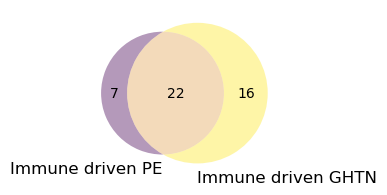

In [12]:
# Venn diagram of immune-driven PE vs immune-driven GHTN

# DEG genes
deg_immune_driven_pe_only = set(fig3_de_data.loc[
    (fig3_de_data["analysis"] == "Immune driven PE vs non HDP") 
    & (fig3_de_data.pvalue_adj < 0.05)
]["feature"])
deg_immune_driven_ghtn_only = set(fig3_de_data.loc[
    (fig3_de_data["analysis"] == "Immune driven GHTN vs non HDP") 
    & (fig3_de_data.pvalue_adj < 0.05)
]["feature"])

# Plot Venn Diagram
fig, ax  = plt.subplots(figsize=(2.5,4))
_ = venn2(
    subsets=(deg_immune_driven_pe_only, deg_immune_driven_ghtn_only),
      set_labels=("Immune driven PE", "Immune driven GHTN"), 
      set_colors = [[r,g,b] for r,g,b,a in plt.get_cmap("viridis",2).colors])
plt.show()

# Figure 4a & b

* Figure 4a: Placental-driven HDP versus all others
* Figue 4b: Placental-driven HDP versus all without high risk factors 

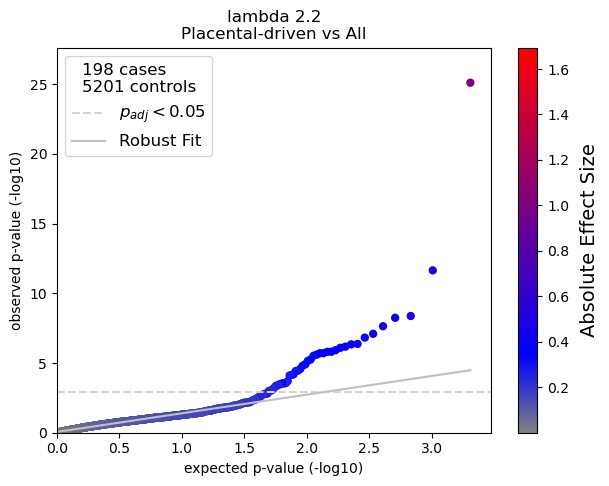

  feature        pvalue  cohens_d
0  PAPPA2  7.746916e-26  1.005365
1   CD163  2.241749e-12  0.531691
2   VSIG4  4.222232e-09  0.480664




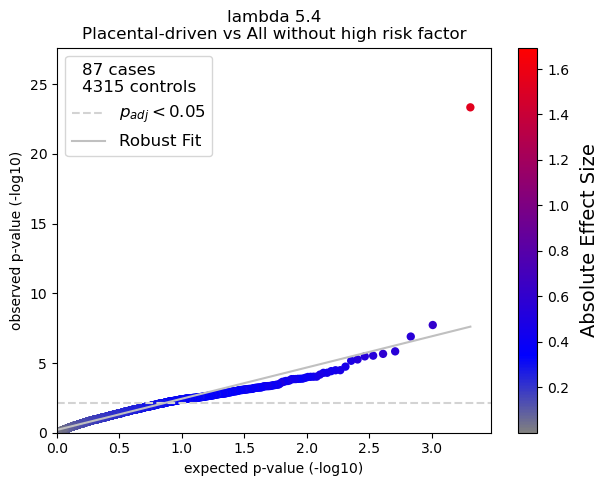

  feature        pvalue  cohens_d
0  PAPPA2  4.518104e-24  1.539630
1  ADAM12  1.871240e-08  0.614616
2   XAGE2  1.262447e-07  0.552106
3   KISS1  1.455827e-06  0.555073




In [13]:
# Generate QQ plot and Top DE gene list for 4a and 4b
plot_qq_set(
    df = fig4ab_de_data,
    eval_list = [
        ("Placental-driven vs All", 3), 
        ("Placental-driven vs All without high risk factor", 4)
    ]
)

# Figure 4d

Classifier prediction across placental-driven HDP by gestational age at delivery in individuals without high risk factors.

In [14]:
sample_data_scaled["hdp_severity_vanity"].value_counts()

hdp_severity_vanity
control             4133
Immune-driven       1055
Placental-driven     198
Name: count, dtype: int64

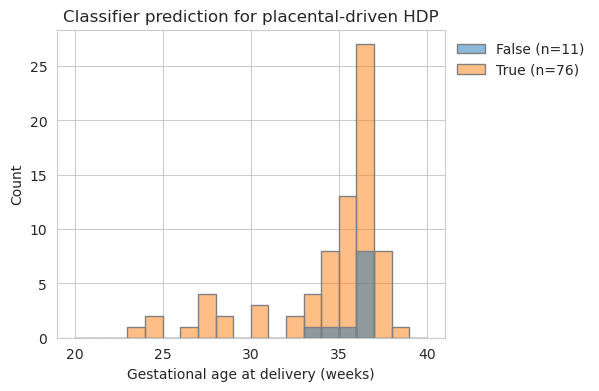

In [15]:
# Select placental-driven HDP w/o high risk factors
df = sample_data_scaled[
    (sample_data_scaled["is_nmrf"] == True) 
    & (sample_data_scaled["hdp_severity_vanity"] == "Placental-driven")
].dropna(subset=["pe_pred_class_full"]).reset_index(drop=True).copy()

# Annotate sample count to prediction class
count_df = df["pe_pred_class_full"].value_counts()
name_map = {
    False: f"False (n={count_df[False]})",
    True: f"True (n={count_df[True]})"
}
df["label"] = df["pe_pred_class_full"].map(name_map)

# Generate histogram plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(5,4))
assert df["delivery_ga"].min()-1 > 20, "Points less than/equal to 21, adjust x-axis min"
assert df["delivery_ga"].max()+1 < 40, "Points greater than/equal to 39, adjust x-axis max"
g= sns.histplot(data=df, x="delivery_ga", hue = "label", hue_order = [name_map[False], name_map[True]], 
                binrange=[20,41], bins=np.arange(20, 41, 1),
                discrete=False, edgecolor="gray", linewidth=1) 
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=False, title=None)
plt.xlabel("Gestational age at delivery (weeks)")
plt.title("Classifier prediction for placental-driven HDP")
plt.xticks(range(20,41, 5))
plt.show()


# Extended Data Fig. 1a

Corrected PAPPA2 log2cpm counts as a function of gestational age at delivery for PE (orange) and all other samples (blue).

Gestational age at delivery (weeks), PAPPA2 (corrected log2cpm), r2: {False: 0.00038583871849171404, True: 0.14092173538741284}


Number of scatter points to add (skip if >= 200): 651



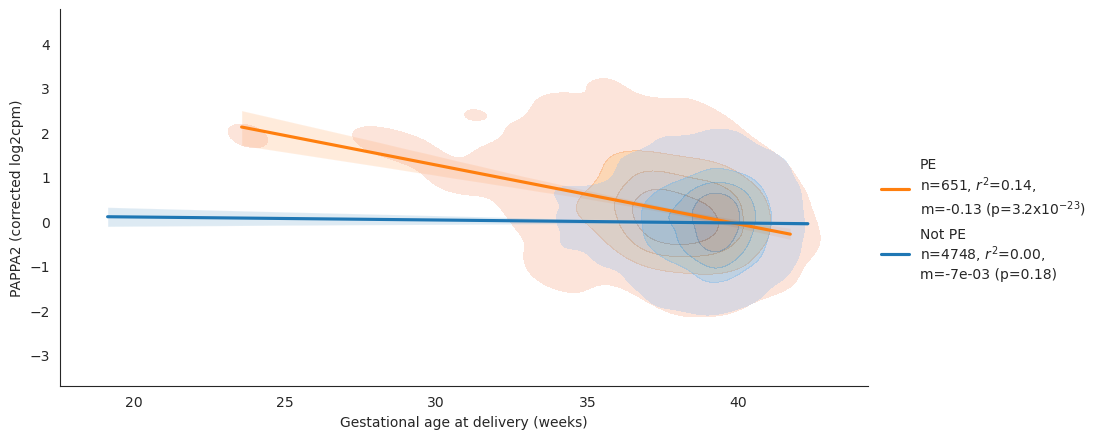

In [16]:
# PE vs not PE
scatter_plot_with_fits(
    df=sample_data_scaled,     
    y_label="PAPPA2",
    y_vanity_label = "PAPPA2 (corrected log2cpm)",
    x_label="delivery_ga",
    x_vanity_label = "Gestational age at delivery (weeks)",
    prediction_label = "is_pe",
    prediction_vanity_label = "PE"
)

# Extended Data Fig. 1b

Corrected PAPPA2 log2cpm counts as a function of gestational age at diagnosis for PE

In [17]:
sample_data_scaled["hdp_vanity_group"].value_counts()

hdp_vanity_group
Control                                   4133
GHTN                                       615
Preterm PE, Severe                         158
Term PE,  Not Severe, Term Diagnosis       140
Term PE, Severe, Term Diagnosis            132
Postpartum PE                              114
Term PE, Not Severe, Preterm Diagnosis      54
Term PE, Severe, Preterm Diagnosis          22
Preterm PE, Not Severe                      18
PE, Ambiguous                               13
Name: count, dtype: int64

Gestational age at PE diagnosis (weeks), PAPPA2 (corrected log2cpm), r2: {False: nan, True: 0.0968165439602563}

No samples apply for Not PE
n=nan, $r^2$=nan,
m=nan (p=nan), skipping

Number of scatter points to add (skip if >= 200): 636



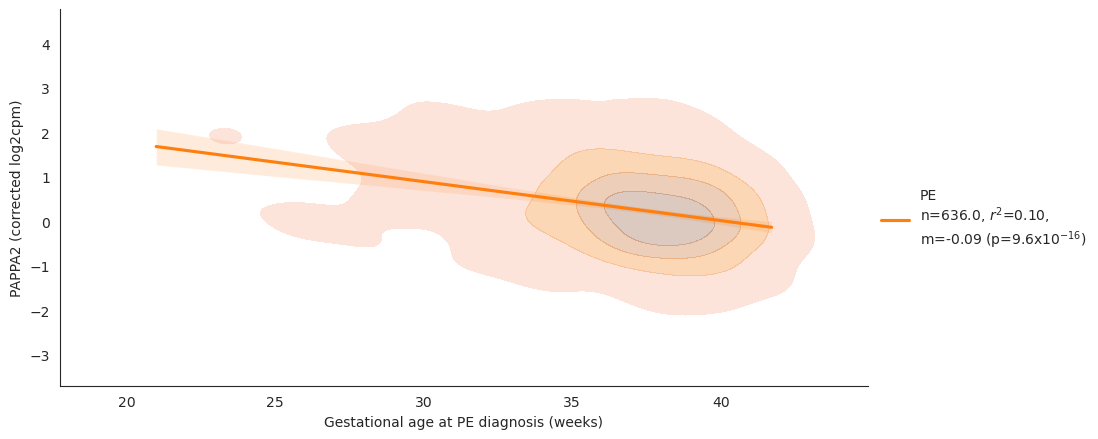

In [18]:
# PE
scatter_plot_with_fits(
    df=sample_data_scaled[
        (~sample_data_scaled["hdp_vanity_group"].isin(["Control", "GHTN"]))
    ].dropna(subset=["is_severe_pe", "pe_ga"]).reset_index(drop=True), #drop samples missing is_severe_pe to match samples in Extended Data Fig. 1c
    y_label="PAPPA2",
    y_vanity_label = "PAPPA2 (corrected log2cpm)",
    x_label="pe_ga",
    x_vanity_label = "Gestational age at PE diagnosis (weeks)", 
    prediction_label = "is_pe",
    prediction_vanity_label = "PE"
)

# Extended Data Fig 1c

Corrected PAPPA2 log2cpm counts as a function of gestational age at diagnosis for PE with severe features (orange) and PE without severe features (blue)

Gestational age at PE diagnosis (weeks), PAPPA2 (corrected log2cpm), r2: {False: 0.0014260383043196805, True: 0.15899632729911356}


Number of scatter points to add (skip if >= 200): 395



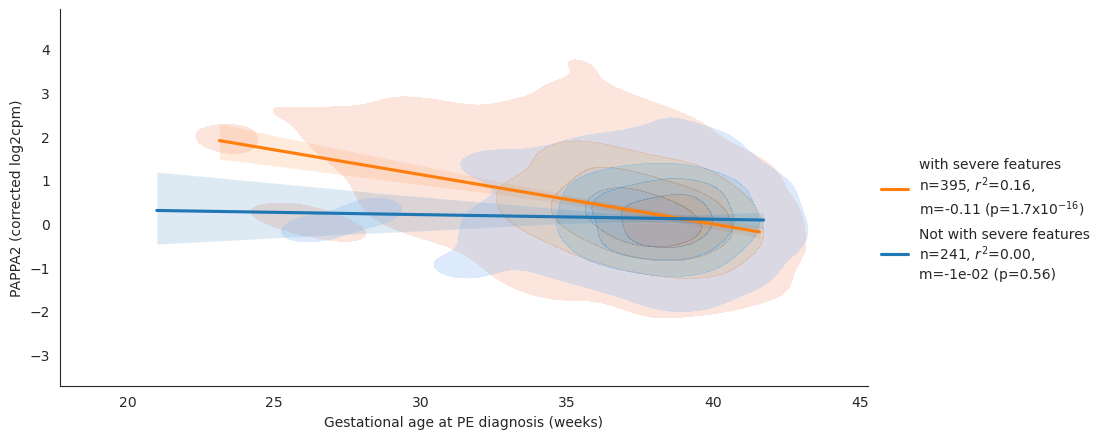

In [19]:
# PE with & without severe features
scatter_plot_with_fits(
    df=sample_data_scaled[
        (~sample_data_scaled["hdp_vanity_group"].isin(["Control", "GHTN"]))
    ].dropna(subset=["is_severe_pe", "pe_ga"]).reset_index(drop=True), 
    y_label="PAPPA2", 
    y_vanity_label = "PAPPA2 (corrected log2cpm)",
    x_label ="pe_ga",
    x_vanity_label="Gestational age at PE diagnosis (weeks)", 
    prediction_label = "is_severe_pe",
    prediction_vanity_label = "with severe features"
)

# Extended Data Fig. 3a
Corrected PAPPA2 log2cpm counts as a function of gestational age at delivery for placental-driven (orange) and all other samples (blue) in individuals without high risk factors.

Gestational age at delivery (weeks), No High RF
PAPPA2 (corrected log2cpm), r2: {False: 0.0003534465546022354, True: 0.17249448767561448}


Number of scatter points to add (skip if >= 200): 87



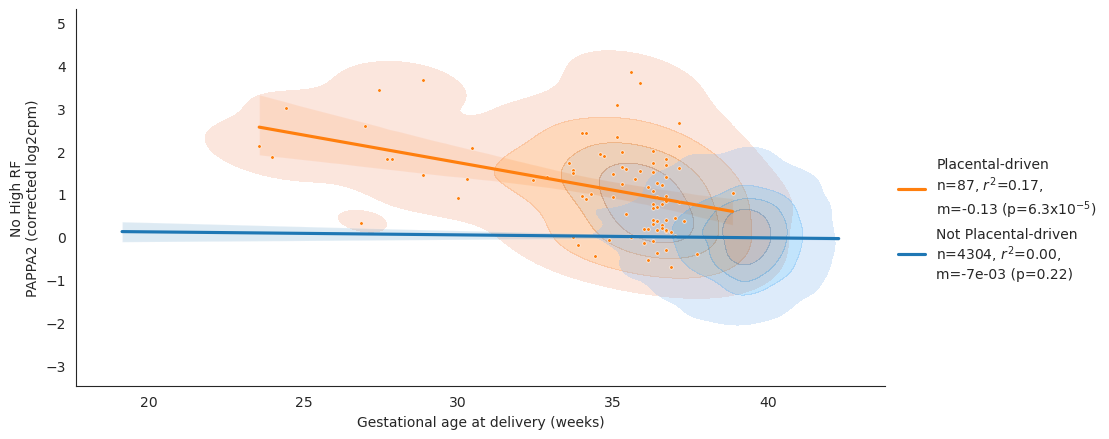

In [20]:
# Placenta-driven versus not
scatter_plot_with_fits(
    df=sample_data_scaled[sample_data_scaled["is_nmrf"] == True].dropna(
        subset="is_placental_driven_hdp"
    ).reset_index(drop=True),     
    y_label="PAPPA2",
    y_vanity_label = "No High RF\nPAPPA2 (corrected log2cpm)",
    x_label="delivery_ga",
    x_vanity_label = "Gestational age at delivery (weeks)",
    prediction_label = "is_placental_driven_hdp",
    prediction_vanity_label = "Placental-driven"
)

# Extended Data Fig 3b

PAPPA2 expression in early-onset PE split into placental-driven and immune-driven HDP. 

In [21]:
sample_data_scaled.groupby("early_onset")["hdp_vanity_group"].value_counts()

early_onset  hdp_vanity_group                      
False        Control                                   4133
             GHTN                                       615
             Term PE,  Not Severe, Term Diagnosis       140
             Term PE, Severe, Term Diagnosis            132
             Postpartum PE                              113
             Preterm PE, Severe                         101
             Term PE, Not Severe, Preterm Diagnosis      42
             Term PE, Severe, Preterm Diagnosis          19
             PE, Ambiguous                               13
             Preterm PE, Not Severe                      11
True         Preterm PE, Severe                          57
             Term PE, Not Severe, Preterm Diagnosis      12
             Preterm PE, Not Severe                       7
             Term PE, Severe, Preterm Diagnosis           3
             Postpartum PE                                1
Name: count, dtype: int64

hdp_severity_vanity
Placental-driven    67
Immune-driven       13
Name: count, dtype: int64


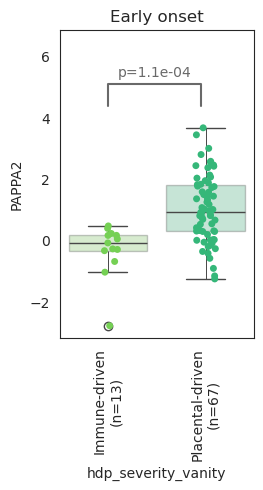

In [22]:
# Select early onset PE
df = sample_data_scaled.dropna(subset=["early_onset"]).reset_index(drop=True)
df = df[
    (df["hdp_vanity_group"] != "PE, Ambiguous")
     & (df["early_onset"] == True)
].reset_index(drop=True)
assert len(df) == 57+12+7+3+1, f"Expect 80 samples, got {len(df)}"
print(df["hdp_severity_vanity"].value_counts(sort=False))

fig = plot_boxplots_with_pvals(
    plot_df=df,
    x="hdp_severity_vanity",
    y="PAPPA2",
    order=[ "Immune-driven", "Placental-driven"],
    contrasts= [("Immune-driven", "Placental-driven")],
    fig_size= (2.5, 4),
    title="Early onset",
    p_sig_thresh = 0.05,
    mw_alt = "two-sided",
    multiple_test_corr_method= "bonferroni",
    palette = green_colors
)

# Extended Data Fig 3c

PAPPA2 expression in PE with severe features split into placental-driven and immune-driven HDP.

In [23]:
sample_data_scaled["hdp_vanity_group"].value_counts()

hdp_vanity_group
Control                                   4133
GHTN                                       615
Preterm PE, Severe                         158
Term PE,  Not Severe, Term Diagnosis       140
Term PE, Severe, Term Diagnosis            132
Postpartum PE                              114
Term PE, Not Severe, Preterm Diagnosis      54
Term PE, Severe, Preterm Diagnosis          22
Preterm PE, Not Severe                      18
PE, Ambiguous                               13
Name: count, dtype: int64

hdp_severity_vanity
Immune-driven       132
Placental-driven    180
Name: count, dtype: int64


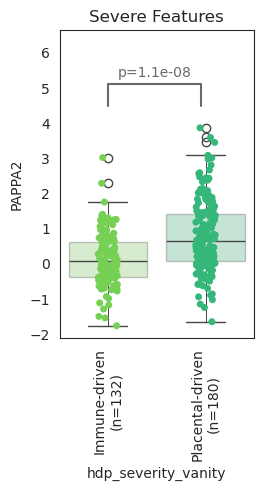

In [24]:
#  Select Severe Features 
df = sample_data_scaled[
    (sample_data_scaled["hdp_vanity_group"] != "PE, Ambiguous")
    & (sample_data_scaled["hdp_vanity_group"].isin([
        "Preterm PE, Severe", 
        "Term PE, Severe, Preterm Diagnosis", 
        "Term PE, Severe, Term Diagnosis"      
        ])
      )
].reset_index(drop=True)
assert len(df) == 158+132+22, f"Expect 312 samples, got {len(df)}"
print(df["hdp_severity_vanity"].value_counts(sort=False))


fig = plot_boxplots_with_pvals(
    plot_df=df,
    x= "hdp_severity_vanity",
    y="PAPPA2",
    order=[ "Immune-driven", "Placental-driven"],
    contrasts= [("Immune-driven", "Placental-driven")],
    fig_size= (2.5, 4),
    title="Severe Features",
    p_sig_thresh = 0.05,
    mw_alt = "two-sided",
    multiple_test_corr_method= "bonferroni",
    palette = green_colors
    )

# Supplementary Table 1

Differential genes between placental-driven and immune-driven HDP.


In [25]:
# DEG performance
assert (suppl_tbl1_data["analysis"] == "Placental-driven vs Immune-driven").all(), "Expect a single analysis, aborting"
df = suppl_tbl1_data.sort_values(by="pvalue", ascending = True)
print(f"Number of Placental-driven HDP samples: {df["n_cases"].unique()}")
print(f"Number of Immune-driven HDP samples: {df["n_control"].unique()}")
df.loc[df["pvalue_adj"] < 0.05, ["feature", "pvalue_adj", "cohens_d"]]

Number of Placental-driven HDP samples: [198]
Number of Immune-driven HDP samples: [1055]


,feature,pvalue_adj,cohens_d
0,PAPPA2,9.292602e-14,0.803986
1,XAGE2,1.311529e-02,0.328298
2,PSG11,1.311529e-02,0.333877
3,KISS1,1.408294e-02,0.330111
4,CD163,2.332563e-02,0.314197
5,CAPN6,2.332563e-02,0.364590


# Analysis for Days Spent in the NICU

In [26]:
# Compare NICU days for classifier (main text)

# Filter for NMRF, includes PE and without PE or sPTB
nmrf_nicu_df = sample_data_scaled[
    (sample_data_scaled["is_nmrf"] == True)
    & (sample_data_scaled["n_nicu_days"] > 0)
    & ((sample_data_scaled["is_pe"] == True) | 
      ((sample_data_scaled["is_pe"] == False) & (sample_data_scaled["is_sptb"]==False)))
].dropna(
    subset = ["n_nicu_days", "test_group"] # drop samples without a test prediction
).reset_index(drop=True).copy()

print("\nNMRF NICU moms")
print(nmrf_nicu_df.groupby("nicu_reason")["is_pe"].value_counts())
print(f"\nNumber of moms with NA NICU Reason: {nmrf_nicu_df["nicu_reason"].isna().sum()}")

# Filter for individuals who went to NICU for reasons related to PE
nmrf_nicu_df_filtered = nmrf_nicu_df[
    (nmrf_nicu_df["nicu_reason"] == "Term Birth - Other Reason")  | 
    ((nmrf_nicu_df["nicu_reason"] == "Preterm Birth") & (nmrf_nicu_df["is_pe"] == True))].reset_index(drop=True)
print("\n--- --- ---")
print("\nNMRF NICU moms who went to NICU for reasons related to PE")
print(nmrf_nicu_df_filtered.groupby("test_group")["nicu_reason"].value_counts())

# Compare days spent in NICU between test positive & test negative
print("\nAverage NICU days spent by test positive/negative group:")
print(nmrf_nicu_df_filtered.groupby("test_group")["n_nicu_days"].mean())

# KS test
_, pval = ks_2samp(nmrf_nicu_df_filtered.loc[nmrf_nicu_df_filtered["test_group"]=="test_pos", "n_nicu_days"].reset_index(drop=True), 
                   nmrf_nicu_df_filtered.loc[nmrf_nicu_df_filtered["test_group"]=="test_neg", "n_nicu_days"].reset_index(drop=True))
print(f"\nKS Test: p={pval:.1e}")

print("\nSample size in each group:")
print(nmrf_nicu_df_filtered.groupby("test_group").size())


NMRF NICU moms
nicu_reason                                                 is_pe
Preterm Birth                                               True      43
                                                            False     21
Term Birth - Chorioamionitis                                False     19
                                                            True       2
Term Birth - Fetal Anomaly                                  False      5
                                                            True       1
Term Birth - Maternal Diabetes                              False      3
                                                            True       2
Term Birth - Maternal Medication (not related to diabetes)  True       3
                                                            False      1
Term Birth - Other Reason                                   False    166
                                                            True      26
Name: count, dtype: int64

Number of moms 

In [27]:
# Compare NICU days in cross validation (Supplementary Information)

# Filter for NMRF, includes PE and without PE or sPTB in CV data
nmrf_nicu_df_cv = sample_data_scaled[
    (sample_data_scaled["is_nmrf"] == True)
    & (sample_data_scaled["n_nicu_days"] > 0)
    & ((sample_data_scaled["is_pe"] == True) | 
      ((sample_data_scaled["is_pe"] == False) & (sample_data_scaled["is_sptb"]==False)))
].dropna(
    subset = ["n_nicu_days", "pred_test_pos_in_cv_gt_0pct", "pred_test_pos_in_cv_gte_50pct"] # drop samples not in test set in CV
).reset_index(drop=True).copy()

print("\nNMRF NICU moms in Cross Validation")
print(nmrf_nicu_df_cv["nicu_reason"].value_counts())
print(f"\nNumber of moms with NA NICU Reason: {nmrf_nicu_df_cv["nicu_reason"].isna().sum()}")

# Filter out individuals who went to NICU for reasons related to PE
nmrf_nicu_df_cv_filtered = nmrf_nicu_df_cv[
    (nmrf_nicu_df_cv["nicu_reason"] == "Term Birth - Other Reason")  | 
    ((nmrf_nicu_df_cv["nicu_reason"] == "Preterm Birth") & (nmrf_nicu_df_cv["is_pe"] == True))].reset_index(drop=True)
print("\n--- --- ---")
print("\nNMRF NICU moms who went to NICU for reasons related to PE")
print(nmrf_nicu_df_cv_filtered["nicu_reason"].value_counts())


for name, label in [
    ("Test Positive in >=50% Cross Validation Splits", "pred_test_pos_in_cv_gte_50pct"), 
    ("Test Positive in at least one Cross Validation Split", "pred_test_pos_in_cv_gt_0pct")]:
    # Compare days spent in NICU between test positive & test negative
    print(f"\n> {name}\n") 
    print(f"Average NICU days spent by status:")
    print(nmrf_nicu_df_cv_filtered.groupby(label)["n_nicu_days"].mean())

    print(f"\nDifference in average NICU days: {(nmrf_nicu_df_cv_filtered.groupby(label)["n_nicu_days"].mean().diff()[True]):.2f}")
    
    # KS test
    _, pval = ks_2samp(nmrf_nicu_df_cv_filtered.loc[nmrf_nicu_df_cv_filtered[label]==True, "n_nicu_days"].reset_index(drop=True), 
                       nmrf_nicu_df_cv_filtered.loc[nmrf_nicu_df_cv_filtered[label]==False, "n_nicu_days"].reset_index(drop=True))
    print(f"\nKS Test: p={pval:.1e}")
    
    print("\nSample size in each group:")
    print(nmrf_nicu_df_cv_filtered.groupby(label)["nicu_reason"].value_counts())



NMRF NICU moms in Cross Validation
nicu_reason
Term Birth - Other Reason                                     191
Preterm Birth                                                  64
Term Birth - Chorioamionitis                                   21
Term Birth - Fetal Anomaly                                      6
Term Birth - Maternal Diabetes                                  5
Term Birth - Maternal Medication (not related to diabetes)      4
Name: count, dtype: int64

Number of moms with NA NICU Reason: 8

--- --- ---

NMRF NICU moms who went to NICU for reasons related to PE
nicu_reason
Term Birth - Other Reason    191
Preterm Birth                 43
Name: count, dtype: int64

> Test Positive in >=50% Cross Validation Splits

Average NICU days spent by status:
pred_test_pos_in_cv_gte_50pct
False     5.384615
True     14.358974
Name: n_nicu_days, dtype: float64

Difference in average NICU days: 8.97

KS Test: p=1.4e-03

Sample size in each group:
pred_test_pos_in_cv_gte_50pct  nicu_reas